# Overall Classification

3 different classification tasks:
* Ecoli
* Coliform
* Ecoli + Coliform

Classes are defined through thresholds

# BEAR IN MIND

* **Precision**: How many of our predictions are correct? Precision is the ability of a classifer not to label an instance positive that is actually negative. For each class it is defined as as the ratio of true positives to the sum of true and false positives. Said another way, “for all instances classified positive, what percent was correct?”

* **Recall**: How well do you notice the phenomenon? Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives. Said another way, “for all instances that were actually positive, what percent was classified correctly?”

* **F1 score**: The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.

* **Support**: Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

In [47]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
data_path = os.path.join("..", "..", "data")

dir_store_path = os.path.join(data_path, "temporary results")

full_dataset_path = os.path.join(dir_store_path, "overall_dataset.xlsx")

# Load Data

In [49]:
full_df = pd.read_excel(full_dataset_path)

In [50]:
full_df.columns.to_list()

['DateTime',
 'Site',
 'Technician Water Quality',
 'Technician Counting',
 'Temp C_mean',
 'Temp C_std',
 'Ph_mean',
 'Ph_std',
 'Cond (ms)_mean',
 'Cond (ms)_std',
 'Coliform (1ml)_mean',
 'Coliform (1ml)_std',
 'Ecoli (1ml)_mean',
 'Ecoli (1ml)_std',
 'cso_hinterland',
 'cso_middle',
 'cso_sea',
 'rained',
 'mean_rainfall',
 'tide_value',
 'bacteria_sum']

In [51]:
full_df = full_df[full_df["DateTime"] > "2023-04-01"]

In [52]:
full_df = full_df.drop(
    columns=[
        "Site",
        "Technician Water Quality",
        "Technician Counting",
        "Temp C_std",
        "Ph_std",
        "Cond (ms)_std",
        "Coliform (1ml)_std",
        "Ecoli (1ml)_std",
    ]
)

# Bacteria Sum

In [53]:
bacteria_df = full_df.drop(columns=["Ecoli (1ml)_mean", "Coliform (1ml)_mean"])

<Axes: xlabel='bacteria_sum', ylabel='Count'>

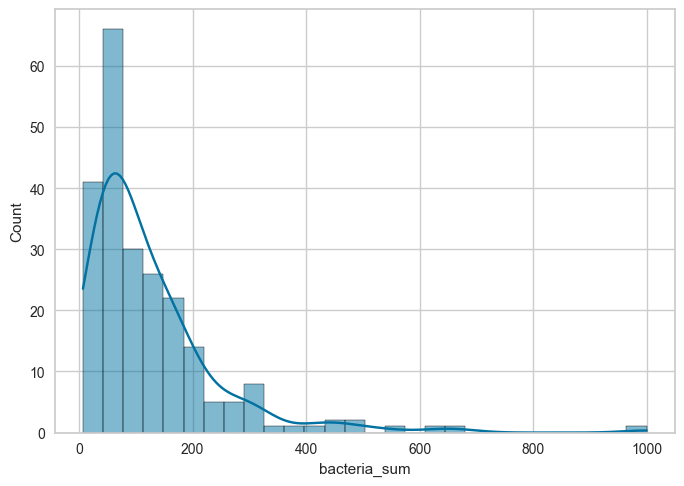

In [54]:
sns.histplot(bacteria_df["bacteria_sum"], kde=True)

In [55]:
# scale to log scale
bacteria_df["bacteria_sum"] = np.log10(bacteria_df["bacteria_sum"])

<Axes: xlabel='bacteria_sum', ylabel='Count'>

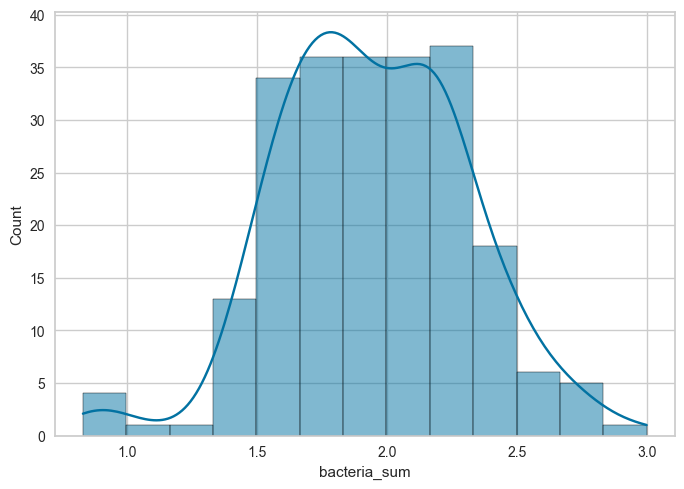

In [56]:
sns.histplot(bacteria_df["bacteria_sum"], kde=True)

## Define classes

In [57]:
print('Threshold:', 10 ** bacteria_df["bacteria_sum"].quantile(0.5))

Threshold: 83.97618710086805


In [58]:
# define function to classify ecoli levels based on quartiles
def ecoli_level(value):
    if value <= bacteria_df["bacteria_sum"].quantile(0.5):
        return "Low"
    else:
        return "High"

In [59]:
# define classes for Ecoli based on quantiles
bacteria_df["Class"] = bacteria_df["bacteria_sum"].apply(ecoli_level)

bacteria_df.drop(columns=["bacteria_sum"], inplace=True)

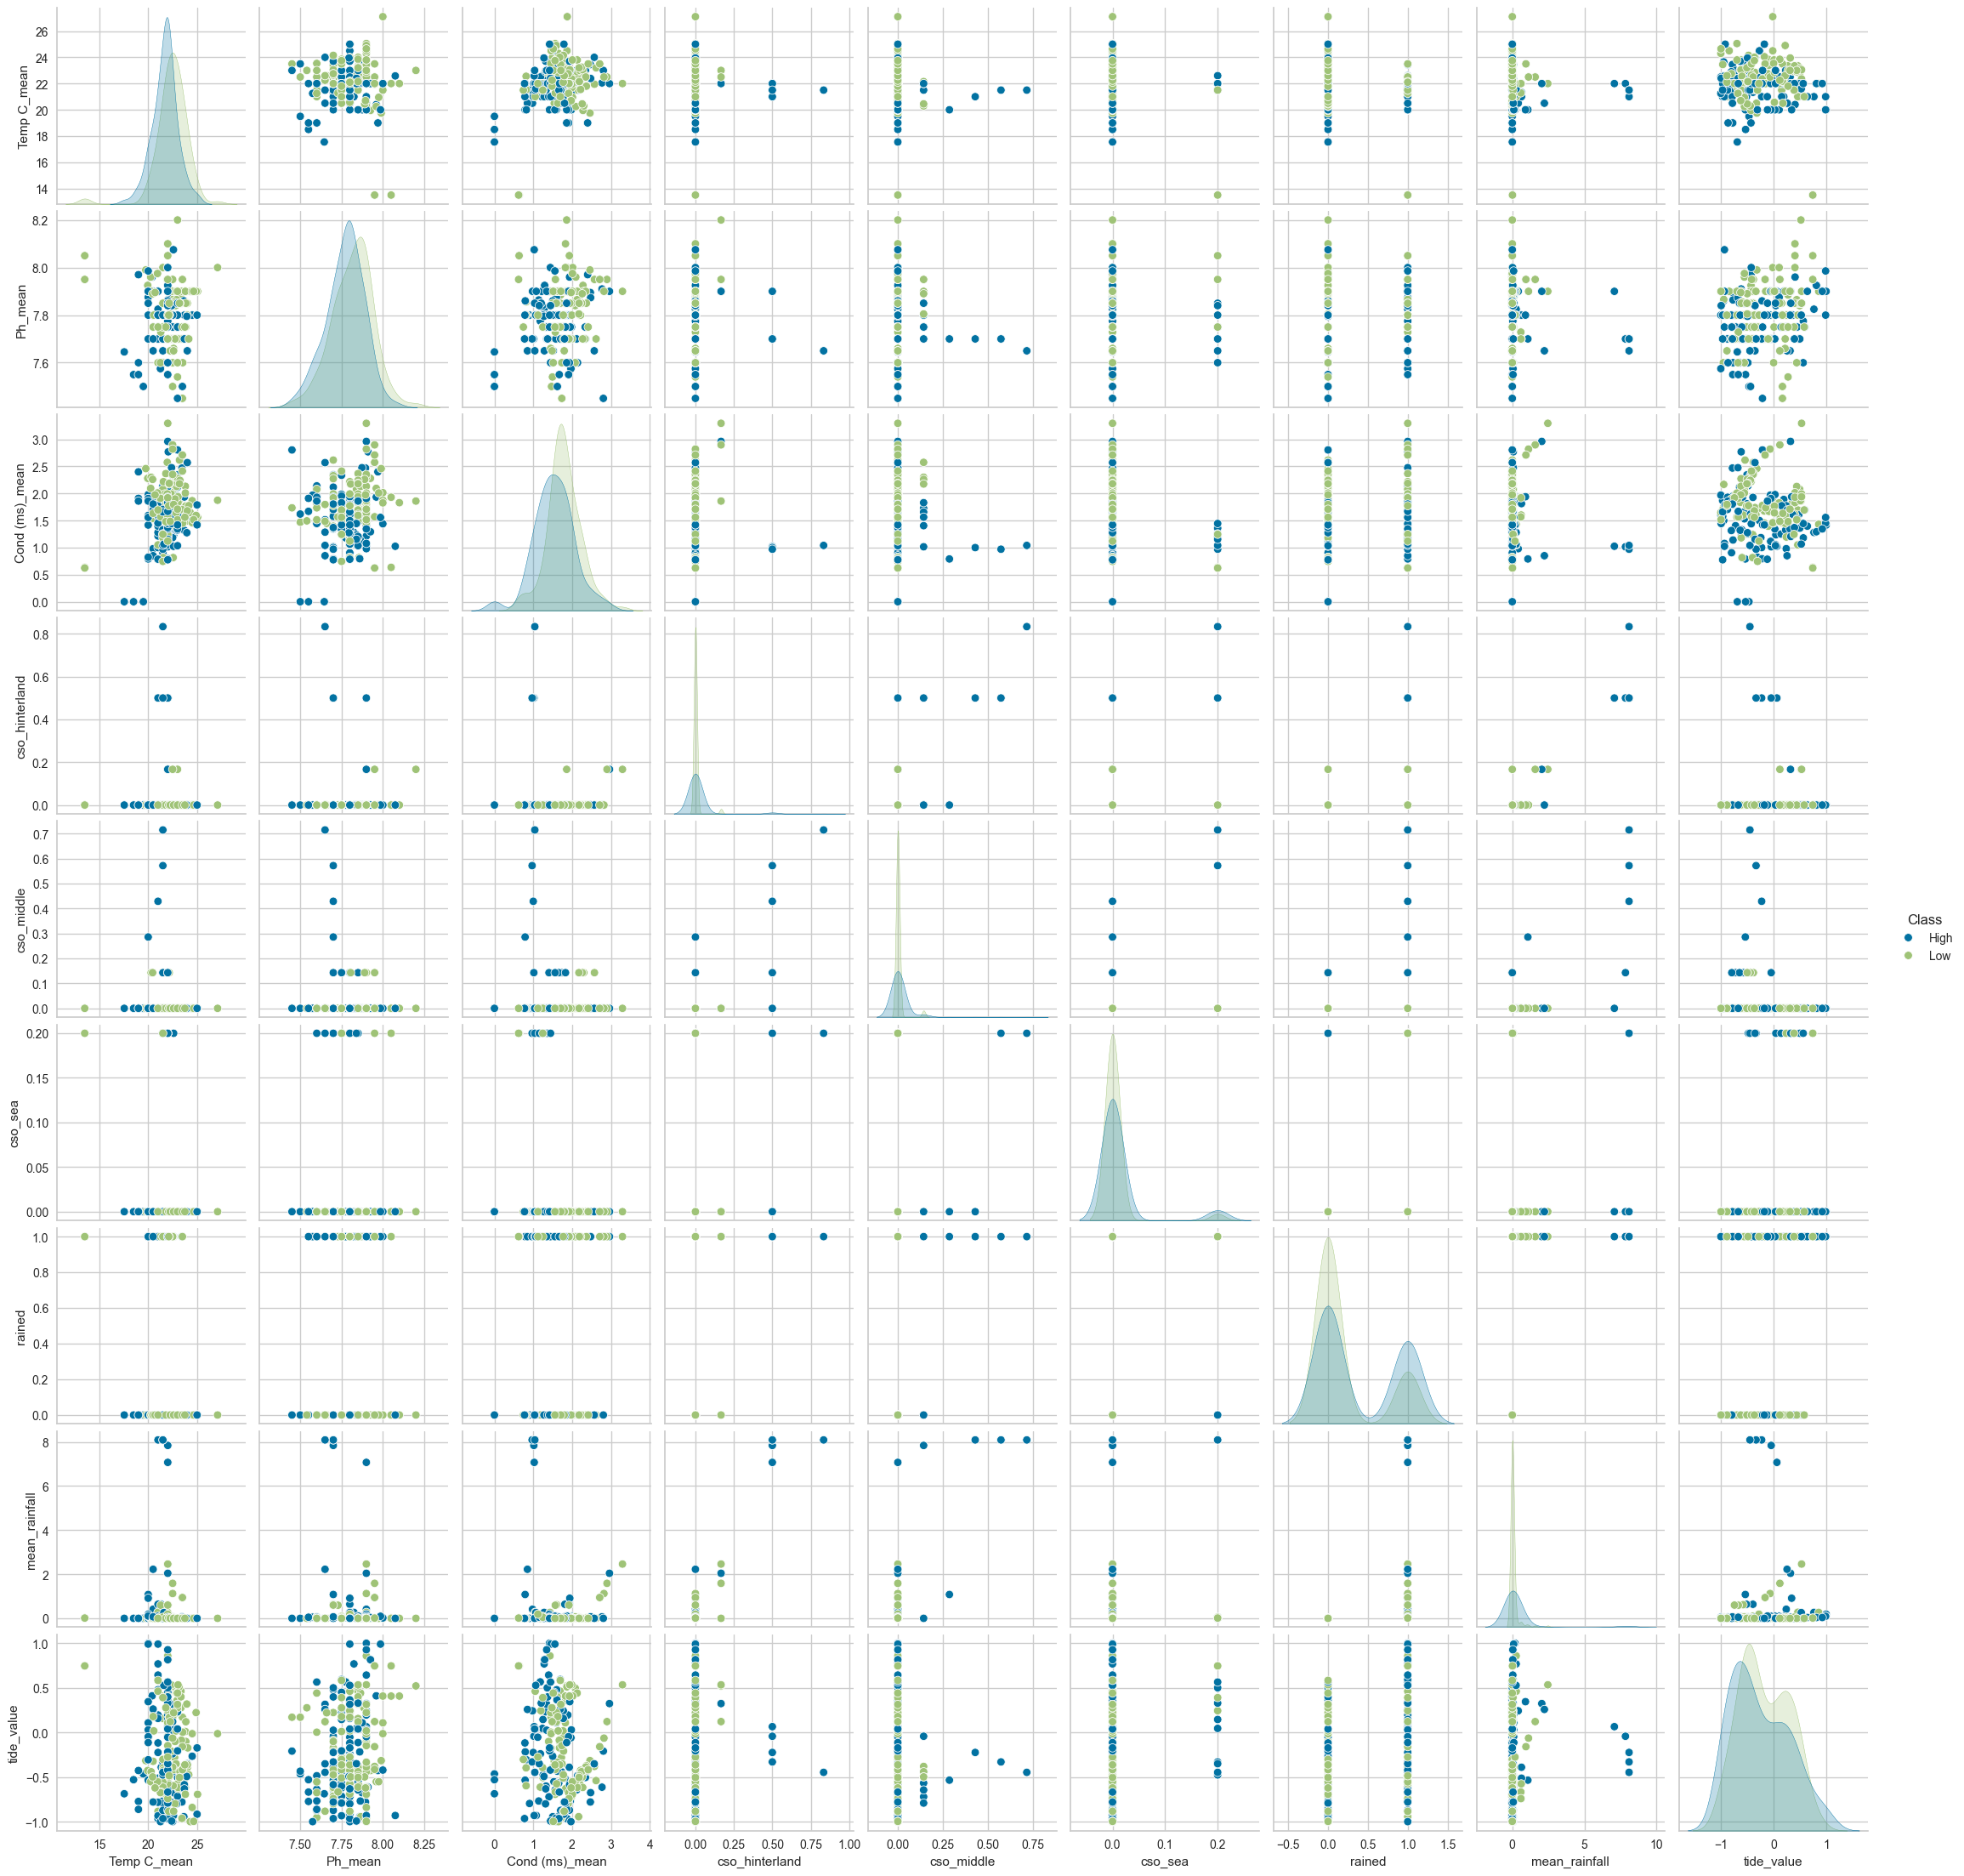

In [60]:
sns.pairplot(bacteria_df, hue="Class")

In [61]:
# count number of samples in each class
bacteria_df["Class"].value_counts()

Class
High    114
Low     114
Name: count, dtype: int64

# Perform Classification

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
import xgboost as xgb

In [63]:
bacteria_df.isna().sum()

DateTime          0
Temp C_mean       0
Ph_mean           0
Cond (ms)_mean    0
cso_hinterland    0
cso_middle        0
cso_sea           0
rained            0
mean_rainfall     0
tide_value        0
Class             0
dtype: int64

In [64]:
X = bacteria_df.drop(
    columns=[
        "DateTime",
        "Class",
    ]
).copy()
y = bacteria_df["Class"].copy()

y = y.map({"Low": 0, "High": 1})

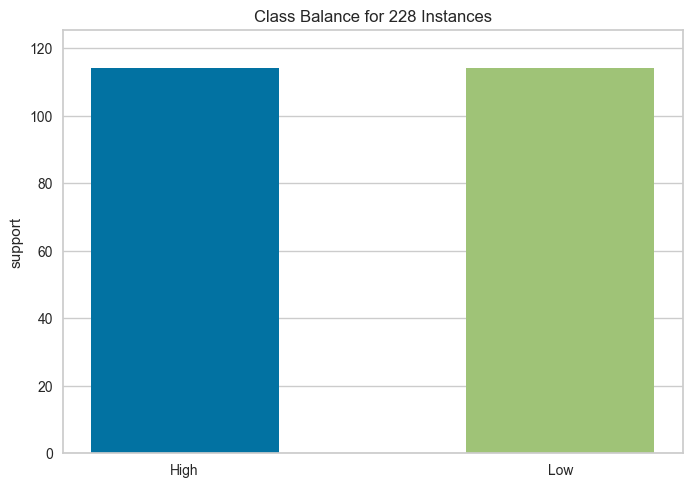

<Axes: title={'center': 'Class Balance for 228 Instances'}, ylabel='support'>

In [65]:
from yellowbrick.classifier import (
    ClassificationReport,
    ROCAUC,
    ClassPredictionError,
    ConfusionMatrix,
    PrecisionRecallCurve,
    ClassBalance,
)


classes = bacteria_df["Class"].unique()

visualizer = ClassBalance(labels=classes)
visualizer.fit(y)
visualizer.show()

# Feature Selection

In [66]:
import warnings
from sklearn import model_selection

In [67]:
%%script false --no-raise-error
from sklearn.feature_selection import SequentialFeatureSelector

selected_features = []

models = [
    LogisticRegression(),
    RandomForestClassifier(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(),
    GaussianNB(),
    SVC(),
    LinearSVC(),
    SGDClassifier(),
    xgb.XGBClassifier(),
]

warnings.filterwarnings("ignore")

for model in models:
    print("=" * 80)
    print(model)
    print("=" * 80)
    print()

    cv = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

    for direction in ["forward", "backward"]:
        print("Direction:", direction)
        print()
        sfs = SequentialFeatureSelector(
            model, n_features_to_select="auto", direction=direction, cv=cv
        )
        sfs.fit(X, y)
        print(X.columns[sfs.get_support()])
        print("-" * 10)

        selected_features.append(X.columns[sfs.get_support()].to_list())


# get the most common features
from collections import Counter

selected_features = Counter(
    [feature for sublist in selected_features for feature in sublist]
)

In [68]:
# selected_features

In [69]:
%%script false --no-raise-error
# Comment this line to keep all features

# Drop the features that are not selected at least half of the times

X.drop(
    columns=[
        "Cond (ms)_mean",
        "Ph_mean",
        "cso_hinterland",
        "cso_middle",
    ],
    inplace=True,
)

# Model Selection

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
)

In [71]:
import optuna

In [72]:
from sklearn import model_selection


def objective(trial):
    classifier_name = trial.suggest_categorical(
        "classifier",
        [
            "RandomForest",
            "XGBoost",
            "LogisticRegression",
            "SVC",
            "KNN",
            "DecisionTree",
            "GaussianNB",
            "LinearSVC",
            "SGDClassifier",
        ],
    )

    if classifier_name == "RandomForest":
        model = RandomForestClassifier(
            random_state=42,
        )

    elif classifier_name == "XGBoost":
        model = xgb.XGBClassifier(
            random_state=42,
        )

    elif classifier_name == "LogisticRegression":
        model = LogisticRegression(
            random_state=42,
        )

    elif classifier_name == "SVC":
        model = SVC(
            random_state=42,
        )

    elif classifier_name == "KNN":
        model = KNeighborsClassifier()

    elif classifier_name == "DecisionTree":
        model = DecisionTreeClassifier(
            random_state=42,
        )

    elif classifier_name == "GaussianNB":
        model = GaussianNB()

    elif classifier_name == "LinearSVC":
        model = LinearSVC(
            random_state=42,
        )

    elif classifier_name == "SGDClassifier":
        model = SGDClassifier(
            random_state=42,
        )

    else:
        raise ValueError("Invalid classifier name")

    cv = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
    results = model_selection.cross_val_score(
        estimator=model, X=X_train, y=y_train, cv=cv, scoring="f1_weighted"
    )
    return results.mean()

In [73]:
study = optuna.create_study(
    direction="maximize",
    storage="sqlite:///bacteria.sqlite3",
    study_name="Model Selection - Bacteria - Overall - After March",
    load_if_exists=True,
)
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2024-03-14 13:28:25,745] A new study created in RDB with name: Model Selection - Bacteria - Overall - After March


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-03-14 13:28:25,800] Trial 0 finished with value: 0.45822639822639816 and parameters: {'classifier': 'SVC'}. Best is trial 0 with value: 0.45822639822639816.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the

[I 2024-03-14 13:28:26,092] Trial 1 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:26,120] Trial 2 finished with value: 0.4469504468391487 and parameters: {'classifier': 'SGDClassifier'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:26,162] Trial 3 finished with value: 0.6910644605091837 and parameters: {'classifier': 'LogisticRegression'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:26,190] Trial 4 finished with value: 0.45822639822639816 and parameters: {'classifier': 'SVC'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:26,214] Trial 5 finished with value: 0.6446582471315906 and parameters: {'classifier': 'DecisionTree'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:26,237] Trial 6 finished with value: 0.43433678084070015 and parameters: {'classifier': 'GaussianNB'}. Best is trial 1 wi

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/massimilianoarca/Library/Cach

[I 2024-03-14 13:28:28,306] Trial 13 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:28,333] Trial 14 finished with value: 0.6662210133132118 and parameters: {'classifier': 'KNN'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:28,375] Trial 15 finished with value: 0.48556437082278325 and parameters: {'classifier': 'LinearSVC'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:28,649] Trial 16 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:28,922] Trial 17 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:28,947] Trial 18 finished with value: 0.6446582471315906 and parameters: {'classifier': 'DecisionTree'}. Best is trial 1 with 

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/massimilianoarca/Library/Cach

[I 2024-03-14 13:28:30,178] Trial 24 finished with value: 0.6850612997875157 and parameters: {'classifier': 'XGBoost'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:30,225] Trial 25 finished with value: 0.48556437082278325 and parameters: {'classifier': 'LinearSVC'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:30,506] Trial 26 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:30,779] Trial 27 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:31,050] Trial 28 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:31,076] Trial 29 finished with value: 0.45822639822639816 and parameters: {'classifier': 'SVC'}. Best is trial 1 with valu

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[I 2024-03-14 13:28:31,898] Trial 32 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:31,926] Trial 33 finished with value: 0.4469504468391487 and parameters: {'classifier': 'SGDClassifier'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:31,967] Trial 34 finished with value: 0.6910644605091837 and parameters: {'classifier': 'LogisticRegression'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:31,994] Trial 35 finished with value: 0.45822639822639816 and parameters: {'classifier': 'SVC'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:32,270] Trial 36 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:32,295] Trial 37 finished with value: 0.6446582471315906 and parameters: {'classifier': 'DecisionTree'}. Best is tri

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[I 2024-03-14 13:28:33,185] Trial 42 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:33,230] Trial 43 finished with value: 0.6910644605091837 and parameters: {'classifier': 'LogisticRegression'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:33,259] Trial 44 finished with value: 0.6662210133132118 and parameters: {'classifier': 'KNN'}. Best is trial 1 with value: 0.7063881872577525.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/massimilianoarca/Library/Cach

[I 2024-03-14 13:28:33,534] Trial 45 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:33,577] Trial 46 finished with value: 0.48556437082278325 and parameters: {'classifier': 'LinearSVC'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:33,859] Trial 47 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:33,884] Trial 48 finished with value: 0.6446582471315906 and parameters: {'classifier': 'DecisionTree'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:34,157] Trial 49 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:34,182] Trial 50 finished with value: 0.43433678084070015 and parameters: {'classifier': 'GaussianNB'}. Best is trial

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/massimilianoarca/Library/Cach

[I 2024-03-14 13:28:35,803] Trial 58 finished with value: 0.6850612997875157 and parameters: {'classifier': 'XGBoost'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:35,850] Trial 59 finished with value: 0.48556437082278325 and parameters: {'classifier': 'LinearSVC'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:36,126] Trial 60 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:36,407] Trial 61 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:36,677] Trial 62 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:36,949] Trial 63 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 w

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[I 2024-03-14 13:28:37,222] Trial 64 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:37,246] Trial 65 finished with value: 0.4469504468391487 and parameters: {'classifier': 'SGDClassifier'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:37,284] Trial 66 finished with value: 0.6910644605091837 and parameters: {'classifier': 'LogisticRegression'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:37,558] Trial 67 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:37,833] Trial 68 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:37,856] Trial 69 finished with value: 0.43433678084070015 and parameters: {'classifier': 'GaussianNB'}. Best

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/massimilianoarca/Library/Cach

[I 2024-03-14 13:28:40,081] Trial 79 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:40,129] Trial 80 finished with value: 0.48556437082278325 and parameters: {'classifier': 'LinearSVC'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:40,405] Trial 81 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:40,679] Trial 82 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:40,950] Trial 83 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[I 2024-03-14 13:28:41,227] Trial 84 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:41,253] Trial 85 finished with value: 0.4469504468391487 and parameters: {'classifier': 'SGDClassifier'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:41,290] Trial 86 finished with value: 0.6910644605091837 and parameters: {'classifier': 'LogisticRegression'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:41,564] Trial 87 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:41,840] Trial 88 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.7063881872577525.
[I 2024-03-14 13:28:42,116] Trial 89 finished with value: 0.7063881872577525 and parameters: {'classifier': 'RandomForest'}. Bes

Since the Condunctivity should be proportional with the tide_value, remove the cond.

Leave just mean_rainfall, tide_value, Temp, rained and cso_sea

In [74]:
study.best_params

{'classifier': 'RandomForest'}

# Hyperparameter Tuning

In [75]:
from sklearn import model_selection


def objective(trial):
    classifier_name = trial.suggest_categorical(
        "classifier", ["RandomForest", "XGBoost", "KNN"]
    )

    if classifier_name == "RandomForest":
        n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
        max_depth = int(trial.suggest_float("max_depth", 10, 100, log=True))
        max_features = trial.suggest_categorical(
            "max_features", ["auto", "sqrt", "log2"]
        )
        criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_features=max_features,
            criterion=criterion,
            random_state=42,
        )

    elif classifier_name == "XGBoost":
        n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
        max_depth = int(trial.suggest_float("max_depth", 10, 100, log=True))
        learning_rate = trial.suggest_float(
            "learning_rate", 0.01, 0.1, log=True
        )
        subsample = trial.suggest_float("subsample", 0.1, 1.0)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
        model = xgb.XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            random_state=42,
        )

    elif classifier_name == "KNN":
        n_neighbors = trial.suggest_int("n_neighbors", 1, 100)
        weights = trial.suggest_categorical("weights", ["uniform", "distance"])
        algorithm = trial.suggest_categorical(
            "algorithm", ["auto", "ball_tree", "kd_tree", "brute"]
        )
        model = KNeighborsClassifier(
            n_neighbors=n_neighbors,
            weights=weights,
            algorithm=algorithm,
        )

    else:
        raise ValueError("Invalid classifier name")

    cv = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
    results = model_selection.cross_val_score(
        estimator=model, X=X_train, y=y_train, cv=cv, scoring="f1_weighted"
    )
    return results.mean()

In [76]:
study = optuna.create_study(
    direction="maximize",
    storage="sqlite:///bacteria.sqlite3",
    study_name="Hyperparameter Tuning - Bacteria - Overall - After March",
    load_if_exists=True,
)
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2024-03-14 13:28:44,358] A new study created in RDB with name: Hyperparameter Tuning - Bacteria - Overall - After March


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:28:44,890] Trial 0 finished with value: 0.7019401466664774 and parameters: {'classifier': 'RandomForest', 'n_estimators': 180, 'max_depth': 68.41024726906618, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 0 with value: 0.7019401466664774.
[I 2024-03-14 13:28:44,922] Trial 1 finished with value: 0.6154460428688386 and parameters: {'classifier': 'KNN', 'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'auto'}. Best is trial 0 with value: 0.7019401466664774.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:28:47,282] Trial 2 finished with value: 0.7171050427479659 and parameters: {'classifier': 'RandomForest', 'n_estimators': 950, 'max_depth': 14.053389769441731, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 2 with value: 0.7171050427479659.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:28:49,268] Trial 3 finished with value: 0.717980942227513 and parameters: {'classifier': 'RandomForest', 'n_estimators': 750, 'max_depth': 11.840445643435892, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 3 with value: 0.717980942227513.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:28:50,424] Trial 4 finished with value: 0.7353657666024688 and parameters: {'classifier': 'XGBoost', 'n_estimators': 630, 'max_depth': 85.21259559685859, 'learning_rate': 0.017431751560484474, 'subsample': 0.16044236494159653, 'colsample_bytree': 0.6973716722425257}. Best is trial 4 with value: 0.7353657666024688.
[I 2024-03-14 13:28:50,457] Trial 5 finished with value: 0.7244956195510697 and parameters: {'classifier': 'KNN', 'n_neighbors': 87, 'weights': 'distance', 'algorithm': 'ball_tree'}. Best is trial 4 with value: 0.7353657666024688.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:28:51,969] Trial 6 finished with value: 0.7045722988849266 and parameters: {'classifier': 'XGBoost', 'n_estimators': 900, 'max_depth': 74.99881919397856, 'learning_rate': 0.06790721276166875, 'subsample': 0.39562708674941083, 'colsample_bytree': 0.1858923908451382}. Best is trial 4 with value: 0.7353657666024688.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or r

[I 2024-03-14 13:28:52,324] Trial 7 finished with value: 0.7065419321636611 and parameters: {'classifier': 'RandomForest', 'n_estimators': 120, 'max_depth': 58.57970202161393, 'max_features': 'auto', 'criterion': 'gini'}. Best is trial 4 with value: 0.7353657666024688.
[I 2024-03-14 13:28:52,356] Trial 8 finished with value: 0.6809362934362935 and parameters: {'classifier': 'KNN', 'n_neighbors': 50, 'weights': 'uniform', 'algorithm': 'ball_tree'}. Best is trial 4 with value: 0.7353657666024688.
[I 2024-03-14 13:28:53,097] Trial 9 finished with value: 0.7130512577775885 and parameters: {'classifier': 'RandomForest', 'n_estimators': 280, 'max_depth': 93.1255433023449, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 4 with value: 0.7353657666024688.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:28:53,911] Trial 10 finished with value: 0.7350774326905586 and parameters: {'classifier': 'XGBoost', 'n_estimators': 530, 'max_depth': 35.46900642976269, 'learning_rate': 0.011593079638612188, 'subsample': 0.10359070956669908, 'colsample_bytree': 0.8964248459295996}. Best is trial 4 with value: 0.7353657666024688.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:28:54,570] Trial 11 finished with value: 0.7458090345487339 and parameters: {'classifier': 'XGBoost', 'n_estimators': 520, 'max_depth': 30.85215887601485, 'learning_rate': 0.011044657552790476, 'subsample': 0.1093705968807378, 'colsample_bytree': 0.9129451154600186}. Best is trial 11 with value: 0.7458090345487339.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:28:55,355] Trial 12 finished with value: 0.7456481593878588 and parameters: {'classifier': 'XGBoost', 'n_estimators': 520, 'max_depth': 27.69938842828677, 'learning_rate': 0.011964291348784432, 'subsample': 0.1355715536312816, 'colsample_bytree': 0.8555312508349528}. Best is trial 11 with value: 0.7458090345487339.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:28:57,061] Trial 13 finished with value: 0.7194368576323822 and parameters: {'classifier': 'XGBoost', 'n_estimators': 420, 'max_depth': 23.184831502542718, 'learning_rate': 0.01073138715479859, 'subsample': 0.9627678245731106, 'colsample_bytree': 0.9487372059005245}. Best is trial 11 with value: 0.7458090345487339.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:28:57,839] Trial 14 finished with value: 0.7234940344647306 and parameters: {'classifier': 'XGBoost', 'n_estimators': 420, 'max_depth': 27.480550457135696, 'learning_rate': 0.02452252133483187, 'subsample': 0.38167299251607956, 'colsample_bytree': 0.6414353911913635}. Best is trial 11 with value: 0.7458090345487339.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:28:58,782] Trial 15 finished with value: 0.6917801724248571 and parameters: {'classifier': 'XGBoost', 'n_estimators': 640, 'max_depth': 41.54128409281494, 'learning_rate': 0.045677838921316306, 'subsample': 0.10408673717263255, 'colsample_bytree': 0.9487597887117657}. Best is trial 11 with value: 0.7458090345487339.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:00,768] Trial 16 finished with value: 0.7122847555352234 and parameters: {'classifier': 'XGBoost', 'n_estimators': 420, 'max_depth': 18.611863671279483, 'learning_rate': 0.018006638500544122, 'subsample': 0.794006270008742, 'colsample_bytree': 0.7535190346698599}. Best is trial 11 with value: 0.7458090345487339.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:02,661] Trial 17 finished with value: 0.7171068805894457 and parameters: {'classifier': 'XGBoost', 'n_estimators': 760, 'max_depth': 43.808671805126444, 'learning_rate': 0.01012730170148632, 'subsample': 0.30666976198043194, 'colsample_bytree': 0.37256726312830035}. Best is trial 11 with value: 0.7458090345487339.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:04,047] Trial 18 finished with value: 0.7179819402041625 and parameters: {'classifier': 'XGBoost', 'n_estimators': 530, 'max_depth': 19.507857637506685, 'learning_rate': 0.01759218043626659, 'subsample': 0.6662907622152333, 'colsample_bytree': 0.4606200303345308}. Best is trial 11 with value: 0.7458090345487339.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:04,744] Trial 19 finished with value: 0.6953651153825302 and parameters: {'classifier': 'XGBoost', 'n_estimators': 350, 'max_depth': 29.368407378582265, 'learning_rate': 0.03399577623445548, 'subsample': 0.288438535661871, 'colsample_bytree': 0.8177195947944229}. Best is trial 11 with value: 0.7458090345487339.
[I 2024-03-14 13:29:04,776] Trial 20 finished with value: 0.6830098236677185 and parameters: {'classifier': 'KNN', 'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'kd_tree'}. Best is trial 11 with value: 0.7458090345487339.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:05,706] Trial 21 finished with value: 0.7412124352613484 and parameters: {'classifier': 'XGBoost', 'n_estimators': 610, 'max_depth': 48.89313618393817, 'learning_rate': 0.01555435649021756, 'subsample': 0.16982012374557526, 'colsample_bytree': 0.6877088940935216}. Best is trial 11 with value: 0.7458090345487339.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:06,795] Trial 22 finished with value: 0.7462336072066666 and parameters: {'classifier': 'XGBoost', 'n_estimators': 630, 'max_depth': 49.616235329117615, 'learning_rate': 0.014143211586433965, 'subsample': 0.2155917420153206, 'colsample_bytree': 0.5843490623648894}. Best is trial 22 with value: 0.7462336072066666.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:07,988] Trial 23 finished with value: 0.7184040007870847 and parameters: {'classifier': 'XGBoost', 'n_estimators': 740, 'max_depth': 34.170856100422746, 'learning_rate': 0.012704606225635288, 'subsample': 0.2653928836527353, 'colsample_bytree': 0.5236452289928479}. Best is trial 22 with value: 0.7462336072066666.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:09,140] Trial 24 finished with value: 0.7124011041885437 and parameters: {'classifier': 'XGBoost', 'n_estimators': 530, 'max_depth': 54.13796682912447, 'learning_rate': 0.024611354275014152, 'subsample': 0.5053064821465266, 'colsample_bytree': 0.8308792985017895}. Best is trial 22 with value: 0.7462336072066666.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:10,337] Trial 25 finished with value: 0.7017792237772371 and parameters: {'classifier': 'XGBoost', 'n_estimators': 840, 'max_depth': 24.011491460373264, 'learning_rate': 0.014126117164502086, 'subsample': 0.23948654604519937, 'colsample_bytree': 0.27956748176457524}. Best is trial 22 with value: 0.7462336072066666.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:11,821] Trial 26 finished with value: 0.717850011410033 and parameters: {'classifier': 'XGBoost', 'n_estimators': 690, 'max_depth': 35.380808989144924, 'learning_rate': 0.023188253360884974, 'subsample': 0.45065077887124544, 'colsample_bytree': 0.8354077676597058}. Best is trial 22 with value: 0.7462336072066666.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:13,507] Trial 27 finished with value: 0.712909257047188 and parameters: {'classifier': 'XGBoost', 'n_estimators': 580, 'max_depth': 16.82447386950899, 'learning_rate': 0.010092433031304335, 'subsample': 0.6094827397502101, 'colsample_bytree': 0.9891538017047212}. Best is trial 22 with value: 0.7462336072066666.
[I 2024-03-14 13:29:13,583] Trial 28 finished with value: 0.685518041864791 and parameters: {'classifier': 'KNN', 'n_neighbors': 100, 'weights': 'uniform', 'algorithm': 'brute'}. Best is trial 22 with value: 0.7462336072066666.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:14,516] Trial 29 finished with value: 0.7516889413781456 and parameters: {'classifier': 'XGBoost', 'n_estimators': 470, 'max_depth': 24.61756064303881, 'learning_rate': 0.013847760668073094, 'subsample': 0.21331011839858727, 'colsample_bytree': 0.5665363719751011}. Best is trial 29 with value: 0.7516889413781456.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:15,315] Trial 30 finished with value: 0.7229308933259803 and parameters: {'classifier': 'RandomForest', 'n_estimators': 300, 'max_depth': 41.19384482439348, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 29 with value: 0.7516889413781456.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:16,136] Trial 31 finished with value: 0.7458167161948375 and parameters: {'classifier': 'XGBoost', 'n_estimators': 480, 'max_depth': 23.247867829724843, 'learning_rate': 0.014018442555610609, 'subsample': 0.1980248948100965, 'colsample_bytree': 0.5871093261150753}. Best is trial 29 with value: 0.7516889413781456.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:16,971] Trial 32 finished with value: 0.7464321521369394 and parameters: {'classifier': 'XGBoost', 'n_estimators': 470, 'max_depth': 22.758481247677253, 'learning_rate': 0.014589124925709445, 'subsample': 0.2252860492446796, 'colsample_bytree': 0.5753647920269935}. Best is trial 29 with value: 0.7516889413781456.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:17,700] Trial 33 finished with value: 0.7468239314896292 and parameters: {'classifier': 'XGBoost', 'n_estimators': 460, 'max_depth': 22.18136028663392, 'learning_rate': 0.020319338166982264, 'subsample': 0.22919702372600637, 'colsample_bytree': 0.5934405601331376}. Best is trial 29 with value: 0.7516889413781456.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:18,527] Trial 34 finished with value: 0.7124896200529902 and parameters: {'classifier': 'XGBoost', 'n_estimators': 460, 'max_depth': 15.804369956767127, 'learning_rate': 0.021024346670857716, 'subsample': 0.31187379828610984, 'colsample_bytree': 0.483091048910969}. Best is trial 29 with value: 0.7516889413781456.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:19,250] Trial 35 finished with value: 0.7113088452810903 and parameters: {'classifier': 'XGBoost', 'n_estimators': 350, 'max_depth': 20.58916185458584, 'learning_rate': 0.030431901929026475, 'subsample': 0.36010429113492143, 'colsample_bytree': 0.5879922490154633}. Best is trial 29 with value: 0.7516889413781456.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or r

[I 2024-03-14 13:29:20,017] Trial 36 finished with value: 0.7181462012946271 and parameters: {'classifier': 'RandomForest', 'n_estimators': 270, 'max_depth': 10.536903322094298, 'max_features': 'auto', 'criterion': 'entropy'}. Best is trial 29 with value: 0.7516889413781456.
[I 2024-03-14 13:29:20,050] Trial 37 finished with value: 0.7025838479993445 and parameters: {'classifier': 'KNN', 'n_neighbors': 47, 'weights': 'distance', 'algorithm': 'brute'}. Best is trial 29 with value: 0.7516889413781456.
[I 2024-03-14 13:29:20,640] Trial 38 finished with value: 0.7517910121771527 and parameters: {'classifier': 'XGBoost', 'n_estimators': 370, 'max_depth': 13.83199606443259, 'learning_rate': 0.0196819812620835, 'subsample': 0.22347237508217688, 'colsample_bytree': 0.44444782903903435}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:21,292] Trial 39 finished with value: 0.7298012355060227 and parameters: {'classifier': 'XGBoost', 'n_estimators': 350, 'max_depth': 13.710541255148263, 'learning_rate': 0.02005384710346603, 'subsample': 0.23821031922399447, 'colsample_bytree': 0.38940574906167874}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:21,885] Trial 40 finished with value: 0.7282897533661935 and parameters: {'classifier': 'RandomForest', 'n_estimators': 220, 'max_depth': 14.46340649725809, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:22,636] Trial 41 finished with value: 0.7453540704327318 and parameters: {'classifier': 'XGBoost', 'n_estimators': 470, 'max_depth': 12.046576704770896, 'learning_rate': 0.015480862092790693, 'subsample': 0.21573499214025618, 'colsample_bytree': 0.5723779617897655}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:23,254] Trial 42 finished with value: 0.7463178204960983 and parameters: {'classifier': 'XGBoost', 'n_estimators': 390, 'max_depth': 21.62685205375452, 'learning_rate': 0.014709326601515365, 'subsample': 0.20417873530331365, 'colsample_bytree': 0.4213252967751173}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:24,167] Trial 43 finished with value: 0.7128501950160888 and parameters: {'classifier': 'XGBoost', 'n_estimators': 380, 'max_depth': 25.186562275568704, 'learning_rate': 0.029184864423593686, 'subsample': 0.3329026381362803, 'colsample_bytree': 0.41765367722838354}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:24,595] Trial 44 finished with value: 0.7341961379986286 and parameters: {'classifier': 'XGBoost', 'n_estimators': 200, 'max_depth': 20.242436804035428, 'learning_rate': 0.018662089348928972, 'subsample': 0.25479586348149386, 'colsample_bytree': 0.4984690516809352}. Best is trial 38 with value: 0.7517910121771527.
[I 2024-03-14 13:29:24,631] Trial 45 finished with value: 0.6763246497264469 and parameters: {'classifier': 'KNN', 'n_neighbors': 72, 'weights': 'uniform', 'algorithm': 'kd_tree'}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:25,327] Trial 46 finished with value: 0.751596785394518 and parameters: {'classifier': 'XGBoost', 'n_estimators': 390, 'max_depth': 16.381212699272485, 'learning_rate': 0.01624420651936832, 'subsample': 0.15938639315667208, 'colsample_bytree': 0.660080249935318}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:25,994] Trial 47 finished with value: 0.7301369577003278 and parameters: {'classifier': 'XGBoost', 'n_estimators': 460, 'max_depth': 16.911564293997905, 'learning_rate': 0.016938170691676187, 'subsample': 0.16700154144299534, 'colsample_bytree': 0.6642882838187032}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or r

[I 2024-03-14 13:29:26,884] Trial 48 finished with value: 0.7121988017640193 and parameters: {'classifier': 'RandomForest', 'n_estimators': 320, 'max_depth': 12.364009568681633, 'max_features': 'auto', 'criterion': 'entropy'}. Best is trial 38 with value: 0.7517910121771527.
[I 2024-03-14 13:29:27,127] Trial 49 finished with value: 0.7133235778655754 and parameters: {'classifier': 'XGBoost', 'n_estimators': 100, 'max_depth': 17.8554809238349, 'learning_rate': 0.02090226508858433, 'subsample': 0.42473827117341356, 'colsample_bytree': 0.3178585532940065}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:27,547] Trial 50 finished with value: 0.7130592506146014 and parameters: {'classifier': 'XGBoost', 'n_estimators': 240, 'max_depth': 15.083237465829626, 'learning_rate': 0.043076145809531785, 'subsample': 0.16365100021447188, 'colsample_bytree': 0.7371309635412776}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:28,144] Trial 51 finished with value: 0.7076350785664317 and parameters: {'classifier': 'XGBoost', 'n_estimators': 400, 'max_depth': 21.887646455238404, 'learning_rate': 0.08597348222779962, 'subsample': 0.19036207663070842, 'colsample_bytree': 0.6226491566190928}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:29,042] Trial 52 finished with value: 0.7184864632376226 and parameters: {'classifier': 'XGBoost', 'n_estimators': 490, 'max_depth': 24.698891350133504, 'learning_rate': 0.013047622391178482, 'subsample': 0.276354410635575, 'colsample_bytree': 0.4514416423863109}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:29,611] Trial 53 finished with value: 0.7458944615488743 and parameters: {'classifier': 'XGBoost', 'n_estimators': 400, 'max_depth': 26.83768745934628, 'learning_rate': 0.015997848369595388, 'subsample': 0.14257793389472884, 'colsample_bytree': 0.5343551675082933}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:30,044] Trial 54 finished with value: 0.7178916422833964 and parameters: {'classifier': 'XGBoost', 'n_estimators': 150, 'max_depth': 13.308664019156264, 'learning_rate': 0.012544871746659228, 'subsample': 0.10305447939526391, 'colsample_bytree': 0.7235409890016239}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:30,678] Trial 55 finished with value: 0.7351245552886019 and parameters: {'classifier': 'XGBoost', 'n_estimators': 440, 'max_depth': 20.889477699712046, 'learning_rate': 0.01608721253765329, 'subsample': 0.21261871145372468, 'colsample_bytree': 0.3226443677590586}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:31,448] Trial 56 finished with value: 0.7246361672261106 and parameters: {'classifier': 'XGBoost', 'n_estimators': 580, 'max_depth': 10.332764686651425, 'learning_rate': 0.011456084826374857, 'subsample': 0.3378973703801457, 'colsample_bytree': 0.21049423563603747}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:31,972] Trial 57 finished with value: 0.7397862117089443 and parameters: {'classifier': 'XGBoost', 'n_estimators': 370, 'max_depth': 18.435568078279864, 'learning_rate': 0.019226401664710374, 'subsample': 0.1478862423057874, 'colsample_bytree': 0.6381836628946979}. Best is trial 38 with value: 0.7517910121771527.
[I 2024-03-14 13:29:32,006] Trial 58 finished with value: 0.7077909009487957 and parameters: {'classifier': 'KNN', 'n_neighbors': 26, 'weights': 'distance', 'algorithm': 'auto'}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:32,866] Trial 59 finished with value: 0.7233338381397666 and parameters: {'classifier': 'XGBoost', 'n_estimators': 310, 'max_depth': 30.8645192162309, 'learning_rate': 0.022654477445045864, 'subsample': 0.9146394067110424, 'colsample_bytree': 0.5389828483203903}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:33,863] Trial 60 finished with value: 0.6947861845672672 and parameters: {'classifier': 'XGBoost', 'n_estimators': 510, 'max_depth': 15.777554979307158, 'learning_rate': 0.02680901903232898, 'subsample': 0.28472445545172614, 'colsample_bytree': 0.4570703302117207}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:35,016] Trial 61 finished with value: 0.7515025300168189 and parameters: {'classifier': 'XGBoost', 'n_estimators': 570, 'max_depth': 69.1307911705752, 'learning_rate': 0.014131144142245861, 'subsample': 0.21465534718531099, 'colsample_bytree': 0.6054257213279426}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:36,091] Trial 62 finished with value: 0.7346255538447981 and parameters: {'classifier': 'XGBoost', 'n_estimators': 570, 'max_depth': 83.9553183725198, 'learning_rate': 0.014330239135747207, 'subsample': 0.243115387499941, 'colsample_bytree': 0.6299223600454518}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:36,707] Trial 63 finished with value: 0.7295303515024266 and parameters: {'classifier': 'XGBoost', 'n_estimators': 440, 'max_depth': 68.41576682123652, 'learning_rate': 0.017428938682173222, 'subsample': 0.12797609849672448, 'colsample_bytree': 0.7747340340838658}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:37,577] Trial 64 finished with value: 0.7409311100394701 and parameters: {'classifier': 'XGBoost', 'n_estimators': 550, 'max_depth': 26.956085766962175, 'learning_rate': 0.01126966696214801, 'subsample': 0.1676026954697414, 'colsample_bytree': 0.6917705627451012}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:38,542] Trial 65 finished with value: 0.7233947254696655 and parameters: {'classifier': 'XGBoost', 'n_estimators': 670, 'max_depth': 21.596777286152374, 'learning_rate': 0.014536846531450284, 'subsample': 0.19487350518393354, 'colsample_bytree': 0.5097646156235028}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:39,371] Trial 66 finished with value: 0.7303166563320389 and parameters: {'classifier': 'XGBoost', 'n_estimators': 420, 'max_depth': 18.630407478428275, 'learning_rate': 0.012721712800181226, 'subsample': 0.3932890726243677, 'colsample_bytree': 0.41774997515061363}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:40,385] Trial 67 finished with value: 0.7076562630457202 and parameters: {'classifier': 'XGBoost', 'n_estimators': 500, 'max_depth': 32.162054213886144, 'learning_rate': 0.017567329279708395, 'subsample': 0.30434059676352343, 'colsample_bytree': 0.5573102649069683}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or r

[I 2024-03-14 13:29:42,936] Trial 68 finished with value: 0.7171050427479659 and parameters: {'classifier': 'RandomForest', 'n_estimators': 960, 'max_depth': 17.11635825968279, 'max_features': 'auto', 'criterion': 'gini'}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:43,644] Trial 69 finished with value: 0.745908864329917 and parameters: {'classifier': 'XGBoost', 'n_estimators': 340, 'max_depth': 22.827933510682154, 'learning_rate': 0.015402093307681816, 'subsample': 0.23592162578866713, 'colsample_bytree': 0.6120346762714525}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:44,088] Trial 70 finished with value: 0.7459142972239404 and parameters: {'classifier': 'XGBoost', 'n_estimators': 270, 'max_depth': 99.14511331380982, 'learning_rate': 0.013362571548764591, 'subsample': 0.12451674595420975, 'colsample_bytree': 0.6614400747856897}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:45,145] Trial 71 finished with value: 0.7467612234188321 and parameters: {'classifier': 'XGBoost', 'n_estimators': 620, 'max_depth': 61.98185283488311, 'learning_rate': 0.011944190442503439, 'subsample': 0.2086562589904401, 'colsample_bytree': 0.5930790843166195}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:46,168] Trial 72 finished with value: 0.7517427258685658 and parameters: {'classifier': 'XGBoost', 'n_estimators': 630, 'max_depth': 70.08157381548212, 'learning_rate': 0.01121861211037781, 'subsample': 0.19543831165650724, 'colsample_bytree': 0.5583314234819191}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:47,778] Trial 73 finished with value: 0.7175210870863046 and parameters: {'classifier': 'XGBoost', 'n_estimators': 610, 'max_depth': 70.14555530305982, 'learning_rate': 0.011978714620849137, 'subsample': 0.7221467421397653, 'colsample_bytree': 0.5575396037730954}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:48,974] Trial 74 finished with value: 0.7291122017430383 and parameters: {'classifier': 'XGBoost', 'n_estimators': 740, 'max_depth': 57.52720570142317, 'learning_rate': 0.010674286462444366, 'subsample': 0.26507094139686516, 'colsample_bytree': 0.6039729121750149}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:49,876] Trial 75 finished with value: 0.7405222323972324 and parameters: {'classifier': 'XGBoost', 'n_estimators': 550, 'max_depth': 62.60380956308263, 'learning_rate': 0.011668298049599493, 'subsample': 0.18909525727843365, 'colsample_bytree': 0.6669899218949444}. Best is trial 38 with value: 0.7517910121771527.
[I 2024-03-14 13:29:49,911] Trial 76 finished with value: 0.7028202060232103 and parameters: {'classifier': 'KNN', 'n_neighbors': 71, 'weights': 'distance', 'algorithm': 'auto'}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:50,812] Trial 77 finished with value: 0.7507087657087658 and parameters: {'classifier': 'XGBoost', 'n_estimators': 670, 'max_depth': 76.36102505094296, 'learning_rate': 0.010166148910055225, 'subsample': 0.10101852083124423, 'colsample_bytree': 0.49232854186306835}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:51,623] Trial 78 finished with value: 0.7505478905478906 and parameters: {'classifier': 'XGBoost', 'n_estimators': 670, 'max_depth': 79.08660633335599, 'learning_rate': 0.010195203503398885, 'subsample': 0.10257764476839709, 'colsample_bytree': 0.4880706979463767}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:52,453] Trial 79 finished with value: 0.7452532744172681 and parameters: {'classifier': 'XGBoost', 'n_estimators': 700, 'max_depth': 80.5470735138114, 'learning_rate': 0.010098545674114896, 'subsample': 0.10702900948620021, 'colsample_bytree': 0.48072104975526725}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:54,627] Trial 80 finished with value: 0.7125419367885075 and parameters: {'classifier': 'RandomForest', 'n_estimators': 830, 'max_depth': 76.22518603151187, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:55,587] Trial 81 finished with value: 0.7401673230230188 and parameters: {'classifier': 'XGBoost', 'n_estimators': 640, 'max_depth': 90.25673540987052, 'learning_rate': 0.011293282079031412, 'subsample': 0.1423355022749755, 'colsample_bytree': 0.5160843606389929}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:56,730] Trial 82 finished with value: 0.7359140632262529 and parameters: {'classifier': 'XGBoost', 'n_estimators': 710, 'max_depth': 64.31848755548971, 'learning_rate': 0.010856343064231161, 'subsample': 0.17549785046826885, 'colsample_bytree': 0.5337717334850515}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:57,602] Trial 83 finished with value: 0.7450360825286423 and parameters: {'classifier': 'XGBoost', 'n_estimators': 670, 'max_depth': 74.06015858178654, 'learning_rate': 0.012400505563253287, 'subsample': 0.10755695717218293, 'colsample_bytree': 0.47496578212780755}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:58,402] Trial 84 finished with value: 0.7451347851347851 and parameters: {'classifier': 'XGBoost', 'n_estimators': 600, 'max_depth': 50.837129581886515, 'learning_rate': 0.010086221419519625, 'subsample': 0.1392982203454537, 'colsample_bytree': 0.5867638896038501}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:29:59,340] Trial 85 finished with value: 0.7351351488540517 and parameters: {'classifier': 'XGBoost', 'n_estimators': 660, 'max_depth': 62.084427869026854, 'learning_rate': 0.013553796244951502, 'subsample': 0.22559360093872288, 'colsample_bytree': 0.4436968716531451}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:30:01,089] Trial 86 finished with value: 0.7182746881953868 and parameters: {'classifier': 'XGBoost', 'n_estimators': 620, 'max_depth': 78.14343062107595, 'learning_rate': 0.012100955330075191, 'subsample': 0.5402091414364862, 'colsample_bytree': 0.5027458214052721}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:30:02,110] Trial 87 finished with value: 0.701523419947333 and parameters: {'classifier': 'XGBoost', 'n_estimators': 790, 'max_depth': 88.61759555651908, 'learning_rate': 0.03403966084925884, 'subsample': 0.18795994814952238, 'colsample_bytree': 0.5562842355995483}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:30:03,224] Trial 88 finished with value: 0.7401673230230188 and parameters: {'classifier': 'XGBoost', 'n_estimators': 720, 'max_depth': 71.99177888222042, 'learning_rate': 0.010761294532015063, 'subsample': 0.15889727752184662, 'colsample_bytree': 0.37843422667127047}. Best is trial 38 with value: 0.7517910121771527.
[I 2024-03-14 13:30:03,261] Trial 89 finished with value: 0.6809764589587384 and parameters: {'classifier': 'KNN', 'n_neighbors': 23, 'weights': 'uniform', 'algorithm': 'kd_tree'}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:30:05,001] Trial 90 finished with value: 0.7235502676881987 and parameters: {'classifier': 'XGBoost', 'n_estimators': 650, 'max_depth': 84.3988243759345, 'learning_rate': 0.016570885982742988, 'subsample': 0.25044802266871014, 'colsample_bytree': 0.6141888362389176}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:30:06,232] Trial 91 finished with value: 0.7460975011681433 and parameters: {'classifier': 'XGBoost', 'n_estimators': 530, 'max_depth': 37.90665694897385, 'learning_rate': 0.013268227567383469, 'subsample': 0.21069365431707995, 'colsample_bytree': 0.56697300181984}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:30:07,172] Trial 92 finished with value: 0.7463296204554604 and parameters: {'classifier': 'XGBoost', 'n_estimators': 450, 'max_depth': 65.85639166304176, 'learning_rate': 0.015132458064506246, 'subsample': 0.22535811826529956, 'colsample_bytree': 0.6524146851263639}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:30:08,586] Trial 93 finished with value: 0.7080168380088188 and parameters: {'classifier': 'XGBoost', 'n_estimators': 580, 'max_depth': 58.54985460235628, 'learning_rate': 0.018899147190613533, 'subsample': 0.2960001943270511, 'colsample_bytree': 0.5863077832276872}. Best is trial 38 with value: 0.7517910121771527.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:30:09,464] Trial 94 finished with value: 0.7629382177208264 and parameters: {'classifier': 'XGBoost', 'n_estimators': 480, 'max_depth': 96.33445608941335, 'learning_rate': 0.013669347834223928, 'subsample': 0.16999785789416977, 'colsample_bytree': 0.524911784666521}. Best is trial 94 with value: 0.7629382177208264.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:30:10,412] Trial 95 finished with value: 0.7395636968050762 and parameters: {'classifier': 'XGBoost', 'n_estimators': 600, 'max_depth': 94.10321973969842, 'learning_rate': 0.012013149156018763, 'subsample': 0.13156927495554216, 'colsample_bytree': 0.5001542225819202}. Best is trial 94 with value: 0.7629382177208264.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:30:11,331] Trial 96 finished with value: 0.7299526611893634 and parameters: {'classifier': 'XGBoost', 'n_estimators': 680, 'max_depth': 98.06641490149468, 'learning_rate': 0.013432175032312086, 'subsample': 0.1573338316200952, 'colsample_bytree': 0.6997428914891535}. Best is trial 94 with value: 0.7629382177208264.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:30:12,081] Trial 97 finished with value: 0.7402406794599237 and parameters: {'classifier': 'XGBoost', 'n_estimators': 490, 'max_depth': 78.59600006013136, 'learning_rate': 0.02281277572650429, 'subsample': 0.1805574308895487, 'colsample_bytree': 0.5377872537532838}. Best is trial 94 with value: 0.7629382177208264.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:25: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:30:13,150] Trial 98 finished with value: 0.7462336072066666 and parameters: {'classifier': 'XGBoost', 'n_estimators': 990, 'max_depth': 11.295090687067812, 'learning_rate': 0.010990885335836899, 'subsample': 0.10090519512456761, 'colsample_bytree': 0.6056864513690321}. Best is trial 94 with value: 0.7629382177208264.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_12425/2044208526.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-14 13:30:14,582] Trial 99 finished with value: 0.7180246523420335 and parameters: {'classifier': 'RandomForest', 'n_estimators': 560, 'max_depth': 12.963040402239013, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 94 with value: 0.7629382177208264.


In [77]:
study.best_params

{'classifier': 'XGBoost',
 'n_estimators': 480,
 'max_depth': 96.33445608941335,
 'learning_rate': 0.013669347834223928,
 'subsample': 0.16999785789416977,
 'colsample_bytree': 0.524911784666521}

# Model Evaluation

In [78]:
if study.best_params["classifier"] == "RandomForest":
    model = RandomForestClassifier(
        n_estimators=study.best_params["n_estimators"],
        max_depth=int(study.best_params["max_depth"]),
        max_features=study.best_params["max_features"],
        criterion=study.best_params["criterion"],
        random_state=42,
    )

elif study.best_params["classifier"] == "XGBoost":
    model = xgb.XGBClassifier(
        n_estimators=study.best_params["n_estimators"],
        max_depth=int(study.best_params["max_depth"]),
        learning_rate=study.best_params["learning_rate"],
        subsample=study.best_params["subsample"],
        colsample_bytree=study.best_params["colsample_bytree"],
        random_state=42,
    )

**Warning Note** on inappropriate usage of cross_val_predict

The result of cross_val_predict may be different from those obtained using cross_val_score as the elements are grouped in different ways. The function cross_val_score takes an average over cross-validation folds, whereas cross_val_predict simply returns the labels (or probabilities) from several distinct models undistinguished. Thus, cross_val_predict is not an appropriate measure of generalization error.

In [79]:
cv = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

# perform cross-validation and store the results
y_pred = model_selection.cross_val_predict(
    model, X, y, cv=cv
)

y_pred_proba = model_selection.cross_val_predict(
    model, X, y, cv=cv, method="predict_proba"
)

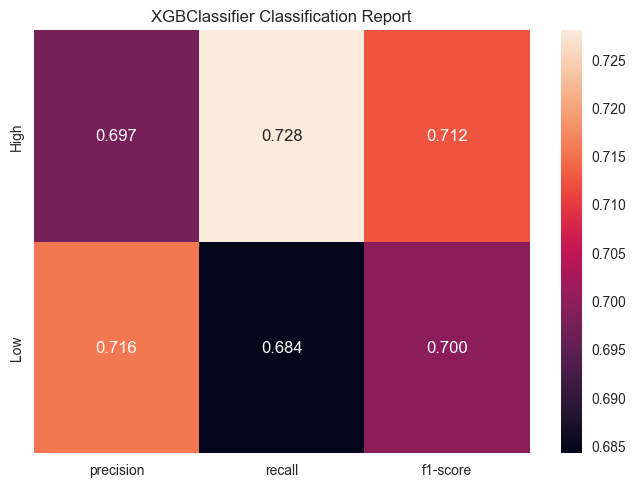

In [80]:
from sklearn.metrics import classification_report


model_name = model.__class__.__name__

report = classification_report(y, y_pred, target_names=classes, output_dict=True)

sns.heatmap(pd.DataFrame(report).iloc[:-1, :-3].T, annot=True, fmt=".3f")

plt.title(f"{model_name} Classification Report")
plt.show()

In [81]:
# accuracy
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

accuracy_score(y, y_pred)

0.706140350877193

In [82]:
f1_score(y, y_pred, average="weighted")

0.7059989607190285

In [83]:
precision_score(y, y_pred, average="weighted")

0.706537660935934

In [84]:
recall_score(y, y_pred, average="weighted")

0.706140350877193

In [85]:
from sklearn.metrics import roc_curve, roc_auc_score

roc_auc_score(y, y_pred_proba[:, 1])

0.7479993844259771

<Figure size 1000x1000 with 0 Axes>

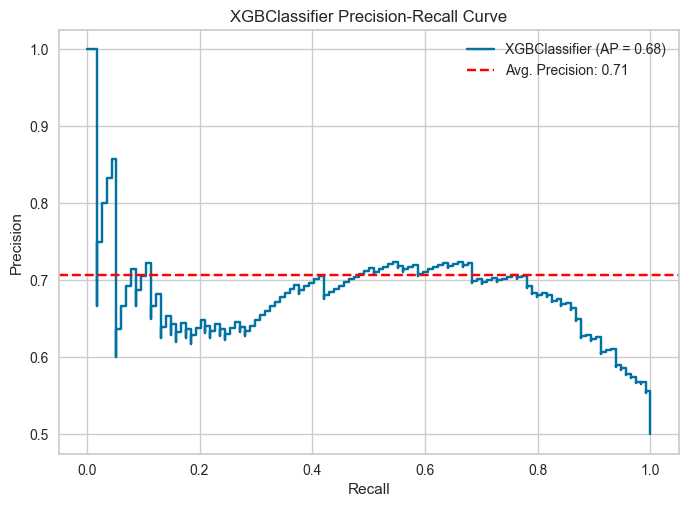

In [86]:
from sklearn.metrics import PrecisionRecallDisplay, precision_score

plt.figure(figsize=(10, 10))
display = PrecisionRecallDisplay.from_predictions(y, y_pred_proba[:, 1], name=f"{model.__class__.__name__}")

# plot avg precision
avg_precision = precision_score(y, y_pred, average="weighted")


plt.axhline(avg_precision, color="red", linestyle="--", label=f"Avg. Precision: {avg_precision:.2f}")

plt.setp(plt.gca(), xlabel="Recall", ylabel="Precision")

plt.title(f"{model.__class__.__name__} Precision-Recall Curve")

plt.legend()

plt.show()


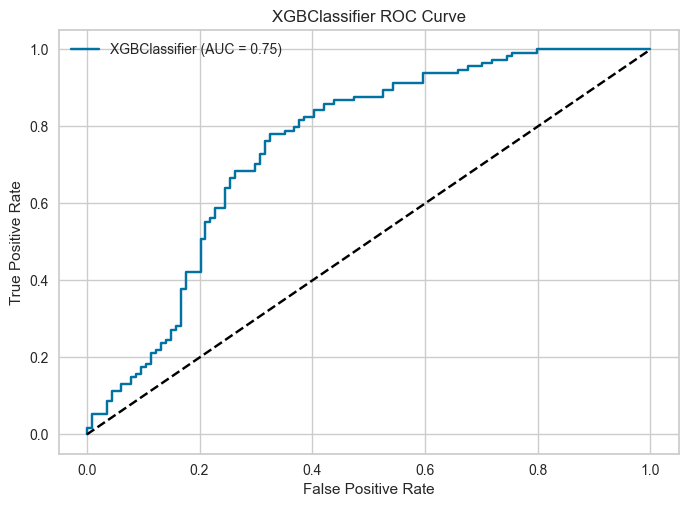

In [87]:
from sklearn.metrics import RocCurveDisplay


RocCurveDisplay.from_predictions(y, y_pred_proba[:, 1], pos_label=1, name=f"{model_name}")

sns.lineplot(
    x=[0, 1],
    y=[0, 1],
    color="black",
    linestyle="--",
)

plt.setp(plt.gca(), xlabel="False Positive Rate", ylabel="True Positive Rate")

plt.title(f"{model.__class__.__name__} ROC Curve")

plt.show()

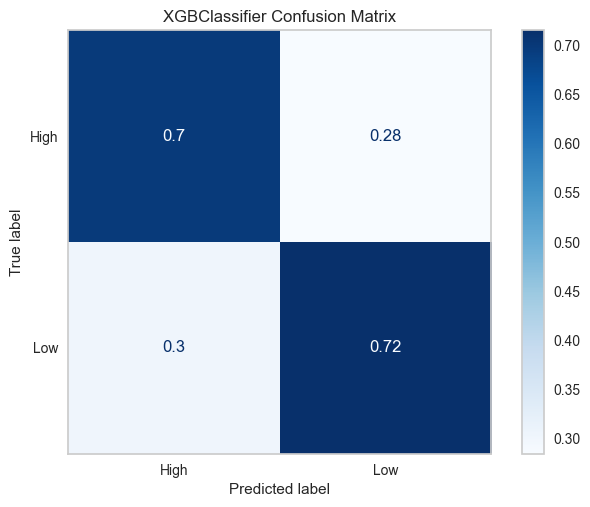

In [88]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y,
    y_pred,
    display_labels=classes,
    normalize="pred",
    cmap="Blues",
)

plt.grid(False)

plt.title(f"{model.__class__.__name__} Confusion Matrix")

plt.show()



# Iteratively Redo Everything with selected model

In [89]:
%%script false --no-raise-error
model = xgb.XGBClassifier(
    n_estimators=study.best_params["n_estimators"],
    max_depth=int(study.best_params["max_depth"]),
    learning_rate=study.best_params["learning_rate"],
    subsample=study.best_params["subsample"],
    colsample_bytree=study.best_params["colsample_bytree"],
    random_state=42,
)


cv = model_selection.KFold(n_splits=20, shuffle=True, random_state=42)

for direction in ["forward", "backward"]:
    print("Direction:", direction)
    print()
    sfs = SequentialFeatureSelector(
        model, n_features_to_select="auto", direction=direction, cv=cv
    )
    sfs.fit(X, y)
    print(X.columns[sfs.get_support()])
    print("-" * 10)

In [90]:
%%script false --no-raise-error
# Drop the features that are not selected at least half of the times

# Comment this line to keep all features
# %%script false --no-raise-error

X_selected = X.drop(
    columns=[
        "cso_sea",
        "cso_hinterland",
        "cso_middle",
    ]
)

In [91]:
%%script false --no-raise-error

from sklearn import model_selection


def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
    max_depth = int(trial.suggest_float("max_depth", 10, 100, log=True))
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1, log=True)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42,
    )

    cv = model_selection.KFold(n_splits=20, shuffle=True, random_state=42)
    results = model_selection.cross_val_score(
        estimator=model, X=X, y=y, cv=cv, scoring="f1_weighted"
    )
    return results.mean()

In [92]:
%%script false --no-raise-error
study = optuna.create_study(
    direction="maximize",
)
study.optimize(objective, n_trials=100, show_progress_bar=True)